In [16]:
import pickle
import networkx as nx
from node2vec import Node2Vec
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from collections import defaultdict
import copy
import matplotlib.pyplot as plt

In [2]:
with open(r"./graphs/bipartite_graph.pickle", "rb") as input_file:
        bipartite_graph = pickle.load(input_file)

In [3]:
print(bipartite_graph)

Graph with 1527 nodes and 347929 edges


In [4]:
def split_train_test(bipartite_graph, test_size=0.2):
    training_graph = bipartite_graph.copy()
    test_edges = []

    user_nodes = {node for node, data in bipartite_graph.nodes(data=True) if data['bipartite'] == 1}
    course_nodes = set(bipartite_graph) - user_nodes

    for user in user_nodes:
        neighbors = [node for node in bipartite_graph.neighbors(user) if node in course_nodes]
        if neighbors:  # Check if the user has rated any course
            num_test = max(1, int(test_size * len(neighbors)))  # Ensure at least 1 test example per user

            test_neighbors = np.random.choice(neighbors, size=num_test, replace=False)
            test_edges.extend([(user, course) for course in test_neighbors])

            for neighbor in test_neighbors:
                if training_graph.has_edge(user, neighbor):  # Check if edge exists before removing
                    training_graph.remove_edge(user, neighbor)

    return training_graph, test_edges




In [5]:
def evaluate_model(test_edges, training_graph, recommendations, top_n):
    hits = 0
    precision_scores = []
    recall_scores = []
    f1_scores = []
    dcg_scores = []

    for user, courses in recommendations.items():
        user_test_courses = [course for user_test, course in test_edges if user_test == user]

        if not user_test_courses:
            continue

        user_training_courses = [course for course in training_graph.neighbors(user) if training_graph.nodes[course]['bipartite'] == 0]
        rec_courses = [course for course, score in courses[:top_n] if course not in user_training_courses]
        hits += len(set(user_test_courses) & set(rec_courses))

        # Calculate Precision, Recall and F1 score
        tp = len(set(user_test_courses) & set(rec_courses))
        fp = len(set(rec_courses) - set(user_test_courses))
        fn = len(set(user_test_courses) - set(rec_courses))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * ((precision * recall) / (precision + recall)) if (precision + recall) > 0 else 0

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

        # Calculate Normalized Discounted Cumulative Gain (NDCG)
        dcg = sum([int(rec_courses[i] in user_test_courses) / np.log2(i + 2) for i in range(min(top_n, len(rec_courses)))])
        idcg = sum([1 / np.log2(i + 2) for i in range(min(top_n, len(user_test_courses)))])
        ndcg = dcg / idcg if idcg > 0 else 0
        dcg_scores.append(ndcg)

    hit_rate = hits / len(test_edges)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)
    mean_ndcg = np.mean(dcg_scores)

    return hit_rate, mean_precision, mean_recall, mean_f1, mean_ndcg


## Personalised PageRank

In [6]:
def remove_same_type_edges(bipartite_graph):
    user_item_graph = bipartite_graph.copy()

    # Create a list to store the edges to remove
    edges_to_remove = []

    # Iterate over the edges
    for edge in user_item_graph.edges():
        # Check if the nodes belong to the same bipartite set
        if user_item_graph.nodes[edge[0]]['bipartite'] == user_item_graph.nodes[edge[1]]['bipartite']:
            edges_to_remove.append(edge)

    # Remove the edges
    user_item_graph.remove_edges_from(edges_to_remove)

    return user_item_graph

In [9]:
def calculate_ppr(bipartite_graph, alpha=0.85, max_iter=100):
    ppr_dict = {}

    # Extract user nodes from the bipartite graph
    user_nodes = {node for node, attr in bipartite_graph.nodes(data=True) if attr['bipartite'] == 1}

    for user_node in user_nodes:
        # Create a personalization dict where only the current user_node has a non-zero value
        personalization = {node: 0 for node in bipartite_graph.nodes()}
        personalization[user_node] = 1

        # Compute personalized PageRank
        ppr = nx.pagerank(bipartite_graph, alpha=alpha, personalization=personalization, max_iter=max_iter, weight='weight')

        # Filter out user nodes and retain only course nodes
        ppr_dict[user_node] = {node: rank for node, rank in ppr.items() if bipartite_graph.nodes[node]['bipartite'] == 0}

    return ppr_dict

def recommend_courses(ppr_dict, bipartite_graph, user_node):
    recommendations = {}

    # Select courses the user has already taken
    taken_courses = {course for course in bipartite_graph.neighbors(user_node) if bipartite_graph.nodes[course]['bipartite'] == 0}

    # Look at each similar user and promote courses that are highly ranked by the similar user
    for similar_user_node, edge_data in bipartite_graph[user_node].items():
        if bipartite_graph.nodes[similar_user_node]['bipartite'] == 1:  # Ensure the node is a user node
            for course_node, ppr_score in ppr_dict[similar_user_node].items():
                # Increase the recommendation score of the course based on the PPR score and the user similarity
                # if course_node not in taken_courses:
                recommendations[course_node] = (recommendations.get(course_node, 0) + ppr_score) * edge_data['weight']

    # Look at each course the user has rated and promote similar courses
    for course_node, edge_data in bipartite_graph[user_node].items():
        if bipartite_graph.nodes[course_node]['bipartite'] == 0:  # Ensure the node is a course node
            sentiment = edge_data['positive_sentiment'] - edge_data['negative_sentiment']
            for similar_course_node in bipartite_graph[course_node]:
                # Increase the recommendation score of the similar course based on the PPR score, course similarity, and sentiments
                if similar_course_node not in recommendations:
                    recommendations[similar_course_node] = edge_data['rating'] * sentiment * ppr_dict[user_node].get(similar_course_node, 0)

    return recommendations


# ppr_dict = calculate_ppr(bipartite_graph)
# recommendations = {user_node: recommend_courses(ppr_dict, bipartite_graph, user_node) for user_node in ppr_dict}
# Step 1: Split data into training set and test set
training_graph, test_edges = split_train_test(bipartite_graph, test_size=0.2)

# Step 2: Generate recommendations based on training data
ppr_dict = calculate_ppr(training_graph)
recommendations = {user_node: sorted(recommend_courses(ppr_dict, training_graph, user_node).items(), key=lambda x: x[1], reverse=True) for user_node in ppr_dict}

# Step 3: Evaluate the model on the test set
hit_rate, mean_precision, mean_recall, mean_f1, mean_ndcg = evaluate_model(test_edges, training_graph, recommendations, top_n=3)

print("Hit Rate: ", hit_rate)
print("Mean Precision: ", mean_precision)
print("Mean Recall: ", mean_recall)
print("Mean F1-Score: ", mean_f1)
print("Mean NDCG: ", mean_ndcg)


Hit Rate:  0.4083333333333333
Mean Precision:  0.235016835016835
Mean Recall:  0.6047286720013992
Mean F1-Score:  0.3187198099319311
Mean NDCG:  0.6125243254619626


## Collaborative Filtering User-User

In [10]:
def recommend_courses_user_based(bipartite_graph, user_node):
    recommendations = defaultdict(int)

    # Get the courses that the user has already taken
    taken_courses = {course for course in bipartite_graph.neighbors(user_node) if bipartite_graph.nodes[course]['bipartite'] == 0}

    # For each similar user...
    for similar_user in bipartite_graph[user_node]:
        # Ensure the node is a user node
        if bipartite_graph.nodes[similar_user]['bipartite'] == 1:
            similarity = bipartite_graph[user_node][similar_user]['weight']  # similarity between users
            # ...get the courses that they have taken...
            other_courses = {course for course in bipartite_graph.neighbors(similar_user) if bipartite_graph.nodes[course]['bipartite'] == 0}
            # ...and for each course that the similar user has taken and the user hasn't...
            for course in other_courses - taken_courses:
                # ...increment the recommendation score for that course by the similarity of the users
                recommendations[course] += similarity

    return recommendations


In [11]:
# Step 1: Split data into training set and test set
training_graph, test_edges = split_train_test(bipartite_graph, test_size=0.2)

# Step 2: Generate recommendations based on training data
recommendations_user_cf = {user_node: sorted(recommend_courses_user_based(training_graph, user_node).items(), key=lambda x: x[1], reverse=True) for user_node in training_graph.nodes() if training_graph.nodes[user_node]['bipartite'] == 1}


# Step 3: Evaluate the model on the test set
hit_rate, mean_precision, mean_recall, mean_f1, mean_ndcg = evaluate_model(test_edges, training_graph, recommendations_user_cf, top_n=3)
print("User Based CF")
print("Hit Rate: ", hit_rate)
print("Mean Precision: ", mean_precision)
print("Mean Recall: ", mean_recall)
print("Mean F1-Score: ", mean_f1)
print("Mean NDCG: ", mean_ndcg)

recommendation_item_cf = {user_node: sorted(recommend_courses_item_based(training_graph, user_node).items(), key=lambda x: x[1], reverse=True) for user_node in training_graph.nodes() if training_graph.nodes[user_node]['bipartite'] == 1}

hit_rate, mean_precision, mean_recall, mean_f1, mean_ndcg = evaluate_model(test_edges, training_graph, recommendation_item_cf, top_n=3)
print("Item Based CF")
print("Hit Rate: ", hit_rate)
print("Mean Precision: ", mean_precision)
print("Mean Recall: ", mean_recall)
print("Mean F1-Score: ", mean_f1)
print("Mean NDCG: ", mean_ndcg)

User Based CF
Hit Rate:  0.4967948717948718
Mean Precision:  0.2609427609427609
Mean Recall:  0.674473939360303
Mean F1-Score:  0.35818285085072044
Mean NDCG:  0.6894268809407134
Item Based CF
Hit Rate:  0.008974358974358974
Mean Precision:  0.0047138047138047135
Mean Recall:  0.01044472502805836
Mean F1-Score:  0.005897572213361687
Mean NDCG:  0.00699591672974343


## Cold Start check
We are going to compare if a global PageRank would perform better than just recommending the most popular elements(approach that CF has to take when the user has no history)

In [12]:
def recommend_courses_global_ppr(bipartite_graph):
    # Compute global PageRank
    global_pr = nx.pagerank(bipartite_graph, alpha=0.85, max_iter=1000000, weight='weight')

    # Filter out user nodes and retain only course nodes
    global_pr = {node: rank for node, rank in global_pr.items() if bipartite_graph.nodes[node]['bipartite'] == 0}

    # Return the courses sorted by their PageRank score (high to low)
    return sorted(global_pr.items(), key=lambda x: x[1], reverse=True)

def recommend_most_popular_courses(bipartite_graph):
    # Count the number of users who have taken each course
    course_popularity = {course: len(list(bipartite_graph.neighbors(course))) for course in bipartite_graph.nodes() if bipartite_graph.nodes[course]['bipartite'] == 0}

    # Return the courses sorted by their popularity (high to low)
    return sorted(course_popularity.items(), key=lambda x: x[1], reverse=True)


Average Global PPR Hit Rate:  0.4882179487179487
Average Popular Courses Hit Rate:  0.4636987179487179


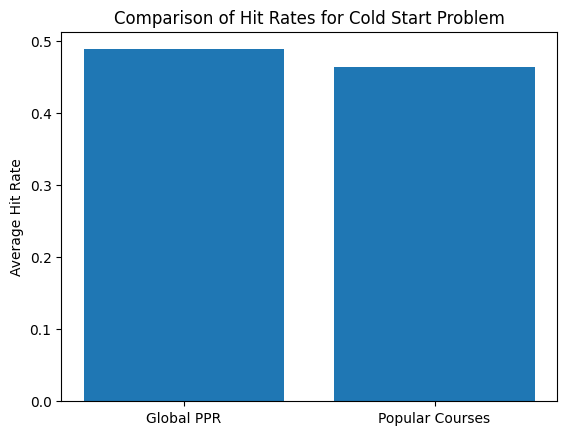

In [18]:
n_iter = 100

# Lists to store hit rates for each method and each iteration
hit_rates_ppr = []
hit_rates_popular = []

for _ in range(n_iter):
    # Split the data
    training_graph, test_edges = split_train_test(bipartite_graph, test_size=0.2)

    # Generate recommendations based on training data
    recommendations_ppr = [course for course, score in recommend_courses_global_ppr(training_graph)[:10]]
    recommendations_popular = [course for course, score in recommend_most_popular_courses(training_graph)[:10]]

    # Lists to store whether a hit occurred for each user
    hits_ppr = []
    hits_popular = []

    # Evaluate the model on the test set
    for user, course in test_edges:
        hits_ppr.append(course in recommendations_ppr)
        hits_popular.append(course in recommendations_popular)

    # Compute hit rate by taking the mean of the hits lists
    hit_rate_ppr = np.mean(hits_ppr)
    hit_rate_popular = np.mean(hits_popular)

    # Store the hit rates for this iteration
    hit_rates_ppr.append(hit_rate_ppr)
    hit_rates_popular.append(hit_rate_popular)

# Compute average hit rates
average_hit_rate_ppr = np.mean(hit_rates_ppr)
average_hit_rate_popular = np.mean(hit_rates_popular)

# Print averages
print("Average Global PPR Hit Rate: ", average_hit_rate_ppr)
print("Average Popular Courses Hit Rate: ", average_hit_rate_popular)

# Create bar chart
plt.bar(["Global PPR", "Popular Courses"], [average_hit_rate_ppr, average_hit_rate_popular])
plt.ylabel("Average Hit Rate")
plt.title("Comparison of Hit Rates for Cold Start Problem")
plt.show()

Average Global PPR Hit Rate:  0.4886538461538462
Average Popular Courses Hit Rate:  0.46446794871794866
Average Global PPR Precision:  0.4886538461538462
Average Popular Courses Precision:  0.46446794871794866
Average Global PPR Recall:  0.4886538461538462
Average Popular Courses Recall:  0.46446794871794866


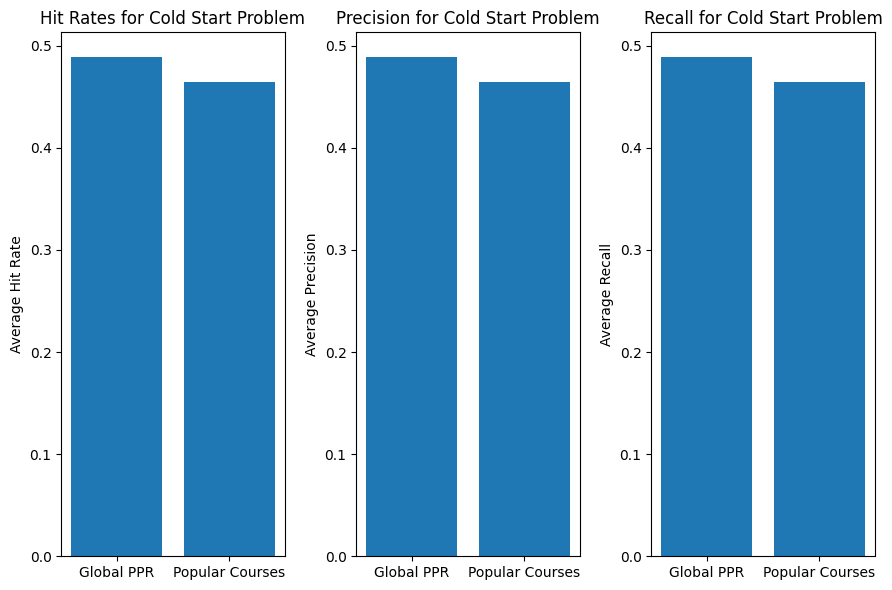

In [20]:
# Number of iterations
n_iter = 100

# Lists to store hit rates, precision, and recall for each method and each iteration
hit_rates_ppr = []
hit_rates_popular = []
precisions_ppr = []
precisions_popular = []
recalls_ppr = []
recalls_popular = []

for _ in range(n_iter):
    # Split the data
    training_graph, test_edges = split_train_test(bipartite_graph, test_size=0.2)

    # Generate recommendations based on training data
    recommendations_ppr = [course for course, score in recommend_courses_global_ppr(training_graph)[:10]]
    recommendations_popular = [course for course, score in recommend_most_popular_courses(training_graph)[:10]]

    # Lists to store whether a hit occurred for each user
    hits_ppr = []
    hits_popular = []

    # Number of relevant items
    relevant_items = len(test_edges)

    # Evaluate the model on the test set
    for user, course in test_edges:
        hits_ppr.append(course in recommendations_ppr)
        hits_popular.append(course in recommendations_popular)

    # Compute hit rate, precision and recall
    hit_rate_ppr = np.mean(hits_ppr)
    hit_rate_popular = np.mean(hits_popular)
    precision_ppr = hit_rate_ppr
    precision_popular = hit_rate_popular
    recall_ppr = sum(hits_ppr) / relevant_items
    recall_popular = sum(hits_popular) / relevant_items

    # Store the hit rates, precisions and recalls for this iteration
    hit_rates_ppr.append(hit_rate_ppr)
    hit_rates_popular.append(hit_rate_popular)
    precisions_ppr.append(precision_ppr)
    precisions_popular.append(precision_popular)
    recalls_ppr.append(recall_ppr)
    recalls_popular.append(recall_popular)

# Compute average hit rates, precisions, and recalls
average_hit_rate_ppr = np.mean(hit_rates_ppr)
average_hit_rate_popular = np.mean(hit_rates_popular)
average_precision_ppr = np.mean(precisions_ppr)
average_precision_popular = np.mean(precisions_popular)
average_recall_ppr = np.mean(recalls_ppr)
average_recall_popular = np.mean(recalls_popular)

# Print averages
print("Average Global PPR Hit Rate: ", average_hit_rate_ppr)
print("Average Popular Courses Hit Rate: ", average_hit_rate_popular)
print("Average Global PPR Precision: ", average_precision_ppr)
print("Average Popular Courses Precision: ", average_precision_popular)
print("Average Global PPR Recall: ", average_recall_ppr)
print("Average Popular Courses Recall: ", average_recall_popular)

# Create bar chart for hit rates
plt.figure(figsize=(9, 6))
plt.subplot(131)
plt.bar(["Global PPR", "Popular Courses"], [average_hit_rate_ppr, average_hit_rate_popular])
plt.ylabel("Average Hit Rate")
plt.title("Hit Rates for Cold Start Problem")

# Create bar chart for precision
plt.subplot(132)
plt.bar(["Global PPR", "Popular Courses"], [average_precision_ppr, average_precision_popular])
plt.ylabel("Average Precision")
plt.title("Precision for Cold Start Problem")

# Create bar chart for recall
plt.subplot(133)
plt.bar(["Global PPR", "Popular Courses"], [average_recall_ppr, average_recall_popular])
plt.ylabel("Average Recall")
plt.title("Recall for Cold Start Problem")

plt.tight_layout()
plt.show()


Average Global PPR Hit Rate:  0.4886538461538462 +- 0.008460809991952369
Average Popular Courses Hit Rate:  0.46446794871794866 +- 0.0092806057629208


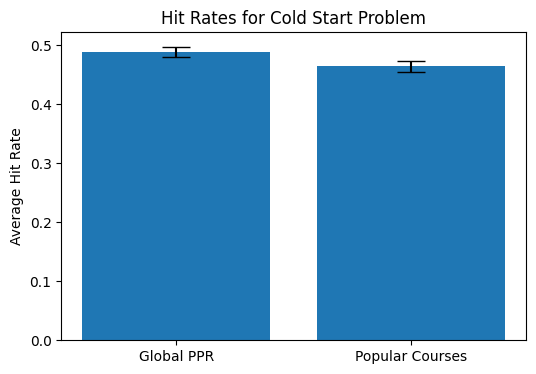

In [21]:
# Compute average hit rates
average_hit_rate_ppr = np.mean(hit_rates_ppr)
average_hit_rate_popular = np.mean(hit_rates_popular)

# Compute standard deviations
std_hit_rate_ppr = np.std(hit_rates_ppr)
std_hit_rate_popular = np.std(hit_rates_popular)

# Print averages and standard deviations
print("Average Global PPR Hit Rate: ", average_hit_rate_ppr, "+-", std_hit_rate_ppr)
print("Average Popular Courses Hit Rate: ", average_hit_rate_popular, "+-", std_hit_rate_popular)

# Create bar chart for hit rates
plt.figure(figsize=(6, 4))
plt.bar(["Global PPR", "Popular Courses"],
        [average_hit_rate_ppr, average_hit_rate_popular],
        yerr=[std_hit_rate_ppr, std_hit_rate_popular],
        capsize=10)
plt.ylabel("Average Hit Rate")
plt.title("Hit Rates for Cold Start Problem")
plt.show()